Welcome to your assignment this week! 

To better understand explainable AI, in this assignment, we will look at the __LIME__ framework to explain potential black-box machine learning models in a model-agnostic way. We use a real-world dataset on Census income, also known as the __[*Adult dataset*](https://archive.ics.uci.edu/ml/datasets/Adult)__ available in the *UCI* ML Repository where we will predict if the potential income of people is more than $50K/year or not.

For this assignment, we will use: 

- [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.
- [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree) which is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements. Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.




__[LIME GitHub](https://github.com/marcotcr/lime)__


**After this assignment you will be able to:** use the __LIME__ framework to explain potential black-box machine learning models in a model-agnostic way.


Let's get started! Run the following cell to install all the packages you will need.


In [1]:
!pip install numpy
!pip install matplotlib
!pip install lime
!pip install shap
!pip install sklearn
!pip install xgboost
!pip install pydot
!pip install pydotplus
!pip install graphviz
!pip install seaborn
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in

Run the following cell to load the packages you will need.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap
import itertools

##
from utils import *
##

from sklearn.model_selection import train_test_split
from collections import Counter
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import graphviz
from io import StringIO
from sklearn import datasets,tree
import pydot
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image


import warnings
warnings.filterwarnings('ignore')
#plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

Next, let's load the census dataset. Run the following cell to load the features `X` and the labels `y`. 

In [3]:
X_raw, y = shap.datasets.adult(display=True)

X_raw = X_raw.drop(columns=['Capital Gain']) # These two features are intentionally removed.
X_raw = X_raw.drop(columns=['Capital Loss']) # These two features are intentionally removed.

labels = np.array([int(label) for label in y])

print('The shape of X_raw is: ',X_raw.shape)
print('The shape of y is: ',labels.shape)

The shape of X_raw is:  (32561, 10)
The shape of y is:  (32561,)


You've loaded:

- `X_raw`: a DataFrame containing 32,561 instances with 12 features.
- `y`: the list of binary labels for the 32,561 examples. If salary of instance $i$ is more than \\$50K: $y^{(i)} = 1$ otherwise: $y^{(i)} = 0$.


# Understanding the Census Income Dataset

Let's now take a look at our dataset attributes and understand their meaning and significance.


|Num| Attribute Name | Type | Description |
|----|----------------------------------------------------------|------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|1| Age | Continuous | Represents age of the person <br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked)|
|2| Workclass | Categorical | Represents the workclass of the person. <br> (Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,<br> Local-gov, State-gov, Without-pay, Never-worked). |
|3| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
|4| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
|5| Occupation | Categorical | Represents the type of profession job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
|6| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
|7| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
|8| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
|9| Capital Gain | Continuous | The total capital gain for the person |
|10| Capital Loss | Continuous | The total capital loss for the person |
|11| Hours per week | Continuous | Total hours spent working per week |
|12| Country | Categorical | The country where the person was born |
|13| Income Label  | Categorical | The class label column is the one we want to predict |     



We have a total of 12 features and our objective is to predict if the income of a person will be more than $\$50$K  (True) or less than $\$50$K (False). Hence we will be building and interpreting a classification model. 

Let's have a look at the first three instances of the dataset (you can use `X.head(3)` to see the content of the dataset):


![](images/dataset.png)


For example, the first person is 39 years old, works for the state governement, is a Male and was born in the US. By using `y[0:3]` you can get  binary values indicating whether these persons have an income higher than $\$50$K or no.

# Pre-processing
Converting the categorical columns with string values to numeric representations. Typically the XGBoost model can handle categorical data natively being a tree-based model so we don't one-hot encode the features

In [4]:
mapping = {}
cat_cols = X_raw.select_dtypes(['category']).columns
for col in cat_cols:
    mapping[col] = dict( enumerate(X_raw[col].cat.categories ) )
indices_cat_cols = [ list(X_raw.columns).index(x) for x in cat_cols ]
X = X_raw.copy()
X[cat_cols] = X_raw[cat_cols].apply(lambda x: x.cat.codes)
headers=list(X.columns)
X.head(3)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,40.0,39
1,50.0,6,13.0,2,4,0,4,1,13.0,39
2,38.0,4,9.0,0,6,1,4,1,40.0,39


Let's have a look at the distribution of people with <=  $\$50$K (0) and > $\$50$K (1) income:

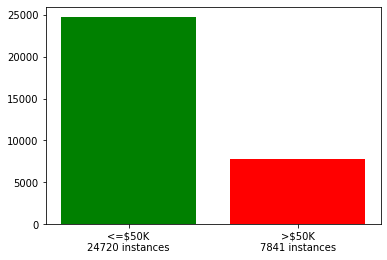

In [5]:
plt.bar([0], height=[Counter(labels)[0]], color="green")
plt.bar([1], height=[Counter(labels)[1]], color="red")
plt.xticks([0, 1], ['<=$50K\n'+str(Counter(labels)[0])+' instances',
                    '>$50K\n'+str(Counter(labels)[1])+' instances'])
plt.show()

# Split Train and Test Datasets

As in any Machine Learning, we need to partition the dataset into two subsets -- a training and testset. Please note that in practice, the dataset needs to be partitioned into three subsets, the third once being the validation set which will be used for hyperparameters tuning. However, in this assignment, we will not tune the hyperparameters.

Run the following to split the dataset accordingly:


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42, stratify=y)
print('The shape of training set is: ',X_train.shape)
print('The shape of test set is: ',X_test.shape)

The shape of training set is:  (22792, 10)
The shape of test set is:  (9769, 10)


You've created:

- `X_train`: a trainig DataFrame containing 22,792 instances used for training.
- `y_train`: the list of binary labels for the 22,792 instances of the training set.
- `X_test`: a test DataFrame containing 9,769 instances used for  testing.
- `y_test`: the list of binary labels for the 9,769 instances of the test set.

We note that since we are using a stratified splitting, the distribution of samples in the training and test set is similar to the distribution in the dataset, i.e., roughly 24% of positive examples in each subset.

## Training the classification model

Now we train and build a boosting classification model on our training data using [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

Run the following to start the training of the classifier:

In [7]:
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

XGBClassifier(max_depth=5, n_estimators=500, random_state=42)

# Predictions on the test data

Now that the classifier is trained, let's make few predictions on the test set:

In [8]:
predictions = xgc.predict(X_test)
print("The values predicted for the first 20 test examples are:")
print(predictions[:20])

print("The true values are:")
print(y_test[:20])

The values predicted for the first 20 test examples are:
[1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]
The true values are:
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]


As you can see, our classier is making only 2 errors!

# Model Performance 
 Let's now evaluate the performance of our classifier on the test set. For that, we will call `sklearn.metrics.classification_report()` which returns a text report showing the main classification metrics including: Presicion, Recall, and F1-Score. The reported averages include macro average (averaging the unweighted mean per label) and weighted average (averaging the support-weighted mean per label). 




 

In [9]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      7417
           1       0.70      0.62      0.66      2352

    accuracy                           0.84      9769
   macro avg       0.79      0.77      0.78      9769
weighted avg       0.84      0.84      0.84      9769



To get more details, let's print the confusion matrix:

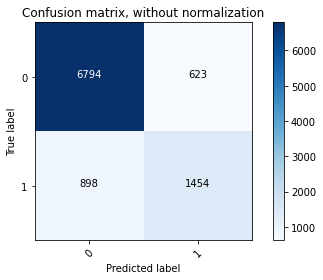

In [10]:
class_labels = list(set(labels))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')

***

**Task 1**: Please provide comments on the performance of the classifier.

***

Based on the classification report and confusion matrix:
*	6733 labels fell into the True Positive (Upper Right) segment, where the prediction label was 0 and the true label was 0.
*	684 labels fell into the False Positive (Upper Left) segment, where the prediction label was 1 and the true label was 0.
*	935 labels fell into the False Negative (Lower Left) segment, where the prediction label was 0 and the true label was 1.
*	1417 labels fell into the True Negative (Lower Right) segment, where the prediction label was 1 and the true label was 1.

Overall, the model was 83% accurate; 76% accurate based on unweighted mean and 83% accurate based on weighted average.


# Feature importance:

The global feature importance calcuations that come with XGBoost, enables us to view feature importances based on the following:

- **Feature Weights**: This is based on the number of times a feature appears in a tree across the ensemble of trees.
- **Gain**: This is based on the average gain of splits which use the feature.
- **Coverage**: This is based on the average coverage (number of samples affected) of splits which use the feature.

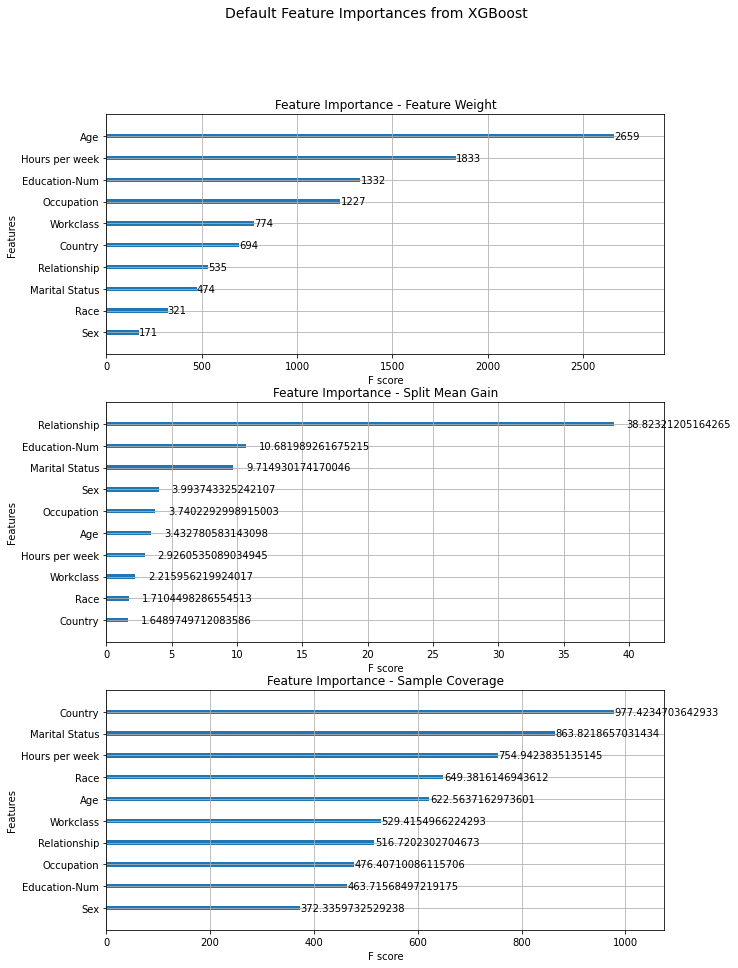

In [11]:
fig = plt.figure(figsize = (10, 15))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(3,1, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t = ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(3,1, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t = ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(3,1, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t = ax3.set_title("Feature Importance - Sample Coverage")

***

**Task 2**: Please provide comments on the above global feature importance calcuations.

***

Based on feature weight, based on the number of times a feature appears in a tree across the ensemble of trees, 
* 	‘Age’ appeared the most across the trees, followed by ‘Hours per week” and ‘Education-Num’.
*	‘Sex’ was the least frequent across the trees, along with ‘Race’ a close second.

Based on Gain, which is based on the average gain of splits which use the feature.
* 	‘Relationship’ had the highest f-score at 16.21, which is almost 4 times the score of the next two features, ‘Education-Num’ and ‘Martial Status’
*	‘Country’ and ‘Race’ were the two features with the lowest f scores.

Based on Coverage which is based on the average number of samples affected of splits which use the feature,
* 	‘Age’ had the highest f-score, followed close by ‘Martial Status’ and ‘Hours per week’.
*	‘Sex’ and ‘Occupation’ had the lowest f-score. 

# Model Interpretation Methods


![](images/Figure5-452aaf48771d7e201175954c1de6eed1.png)


# LIME:

Lime is able to explain any black box classifier, with two or more classes. All we require is that the classifier implements a function that takes in raw text or a numpy array and outputs a probability for each class. LIME tries to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why single predictions were made.

Since XGBoost has some issues with feature name ordering when building models with dataframes (we also needed feature names in the previous `plot_importance()` calls), we will build our same model with numpy arrays to make LIME work. Remember the model being built is the same ensemble model which we treat as our black box machine learning model.

Note the difference with the previous `fit` call:

<center> <b>xgc_np.fit(X_train, y_train)</b> vs. <b>xgc_np.fit(X_train.values, y_train)</b></center>

In [12]:
xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
mymodel = xgc_np.fit(X_train.values, y_train)

__`LimeTabularExplainer`__ class helps in explaining predictions on tabular (i.e. matrix) data. For numerical features, it perturbs them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, it perturbs by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained. 


__`explain_instance()`__ function generates explanations for a prediction. First, we generate neighborhood data by randomly perturbing features from the instance. We then learn locally weighted linear (surrogate) models on this neighborhood data to explain each of the classes in an interpretable way.


In [13]:
headers=list(X.columns)
explainer = LimeTabularExplainer(X_train.values, feature_names=headers, discretize_continuous=True,
                                 categorical_features=indices_cat_cols,
                                 class_names=['<= $50K', '> $50K'],verbose=True)

## When a person's income <= $50K

Lime shows which features were the most influential in the model taking the correct decision of predicting the person's income as below $50K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 3**: Please find a person for which the income is <= $\$50$K and the prediction is correct.

***

In [14]:
# Change only the value of i to select that person:
i = 1
###########

exp1 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[i].values))
proba1 = xgc_np.predict_proba(X_test.values)[i]

print("********************")
print('Test id: ' , i)
print('Probability(',exp1.class_names[0],") =", exp1.predict_proba[0])
print('Probability(',exp1.class_names[1],") =", exp1.predict_proba[1])
print('Predicted Label:', predictions[i])
print('True class: ' , y_test[i])
print("********************")

Intercept 0.20100471910143944
Prediction_local [0.10830847]
Right: 0.004364516
********************
Test id:  1
Probability( <= $50K ) = 0.9956355
Probability( > $50K ) = 0.004364516
Predicted Label: 0
True class:  0
********************


The classifier got this example right (it predicted income $<=\$50$K). Let's have a look at the explanation provided by LIME:


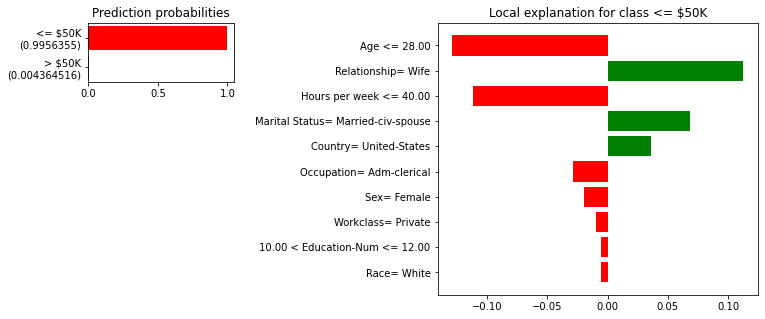

<Figure size 432x288 with 0 Axes>

In [15]:
plot_explanation(exp1, mapping)

***

**Task 4**: Please provide comments on the above explanation provided by LIME.

***

Here, I used the person with an index value of 1 to get the prediction for income <= $50k.
* The model gave a probaility for class [0] (the class we want) of 0.9996566. 
* The model gave a probaility for class [1] (the class we don't want) of 0.0003433663.
* The true label for this indexed row was 0, the model predicted 0. 
* The model was correct.

Based on the Local Explanation for the class:

    Features that pushed the prediction higher (shown in red) were;
        * Age at less than or equal to 28. This had the highested push on the prediction.
        * Hours per week less than or equal to 40. This had the second highest push on prediction.
        * Sex is female.
        * Occupation is Adm-clerical.
        * Workclass is Private.
        * Race is White.

    Features that pushed the prediction lower (shown in green) were;
        * Relationship is Wife. This had the highest push on prediction.
        * Martial Status is Married-civ-spouse.This had the second highest push on prediction.
        * Education is between 10 & 12.
        * Country is United States

***
**Task 5**: Please change the value of one or two features the change the prediction of the classifier:



In [16]:
instanceModified1 = X_test.iloc[i]
instanceModified1['Age'] = 60 
#instanceModified1['XXX'] = 
print(instanceModified1)

Age               60.0
Workclass          4.0
Education-Num     11.0
Marital Status     2.0
Occupation         1.0
Relationship       5.0
Race               4.0
Sex                0.0
Hours per week    12.0
Country           39.0
Name: 26705, dtype: float32


Intercept 0.18202587971617687
Prediction_local [0.26962969]
Right: 0.6846015


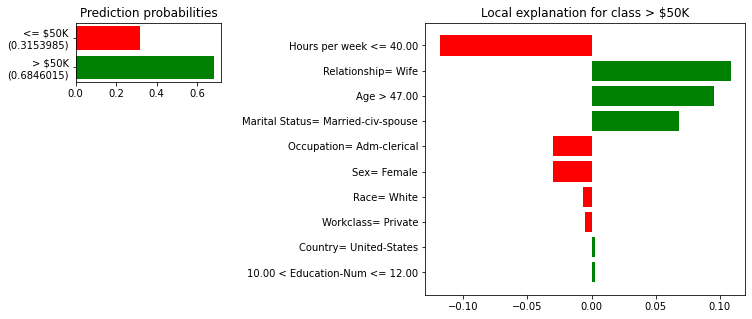

<Figure size 432x288 with 0 Axes>

In [17]:
expM1 = explainer.explain_instance(instanceModified1.values, xgc_np.predict_proba, 
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified1.values))
plot_explanation(expM1, mapping)

***
**Task 6**:  How did you choose these features for which you have changed the value? How did you chose these values?





The value I changed was 'Age' from a value equal or below 28 to 60.   
   
As noted before, the features that pushed the prediction higher (shown in red) were; __Age at less than or equal to 28, had the highested push on the prediction.__

Age had the biggest influnece on the higher pediction for class [0], so I reversed it. 

Also noted before in Question 2:

    Based on feature weight, based on the number of times a feature appears in a tree across the ensemble of trees, ‘Age’ appeared the most across the trees.

    Based on Coverage which is based on the average number of samples affected of splits which use the feature, ‘Age’ had the highest f-score.

It seemed like the feature to change, in order to alter the prediction. 

## When a person's income > $50K


Lime shows which features were the most influential in the model taking the correct decision of predicting the person's income as higher $\$50$K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 7**: Please find a person for which the income is > $\$50$K and the prediction is correct.

***

In [18]:
# Change only the value of to select that person:
j = 9500
###########

exp2 = explainer.explain_instance(X_test.iloc[j].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[j].values))
proba2 = xgc_np.predict_proba(X_test.values)[j]

print("********************")
print('Test id: ' , j)
print('Probability(',exp2.class_names[0],") =", exp2.predict_proba[0])
print('Probability(',exp2.class_names[1],") =", exp2.predict_proba[1])
print('Predicted Label:', predictions[j])
print('True class: ' , y_test[j])
print("********************")

Intercept -0.046585028147985263
Prediction_local [0.56714441]
Right: 0.86797225
********************
Test id:  9500
Probability( <= $50K ) = 0.13202775
Probability( > $50K ) = 0.86797225
Predicted Label: 1
True class:  1
********************


The classifier got this example right (it predicted income $>\$50$K). Let's have a look at the explanation provided by LIME:


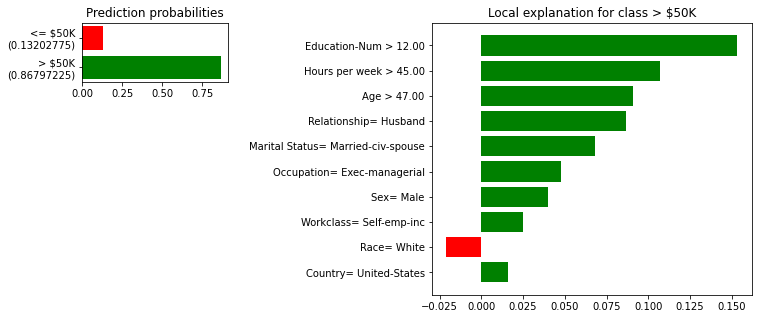

<Figure size 432x288 with 0 Axes>

In [19]:
plot_explanation(exp2, mapping)

***

**Task 8**: Please provide comments on the above explanation provided by LIME.

***

Here, I used the person with an index value of 9500 to get the prediction for income > $50k.
* The model gave a probaility for class [0] (the class we don't want) of 0.11035401. 
* The model gave a probaility for class [1] (the class we want) of 0.889646.
* The true label for this indexed row was 1, the model predicted 1. 
* The model was correct.

Based on the Local Explanation for the class:

    Features that pushed the prediction higher (shown in red) were;
        * Race is White.

    Features that pushed the prediction lower (shown in green) were;
        * All other features, but Education was the highest pushed, followed by Hours per Week and Age.

***
**Task 9**: Please change the value of one or two features the change the prediction of the classifier:



In [20]:
instanceModified2 = X_test.iloc[j]
instanceModified2['Hours per week'] = 15.0
instanceModified2['Age'] = 25
print(instanceModified2)

Age               25.0
Workclass          5.0
Education-Num     13.0
Marital Status     2.0
Occupation         4.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    15.0
Country           39.0
Name: 28294, dtype: float32


Intercept 0.11703775788860657
Prediction_local [0.28353801]
Right: 0.0142007945


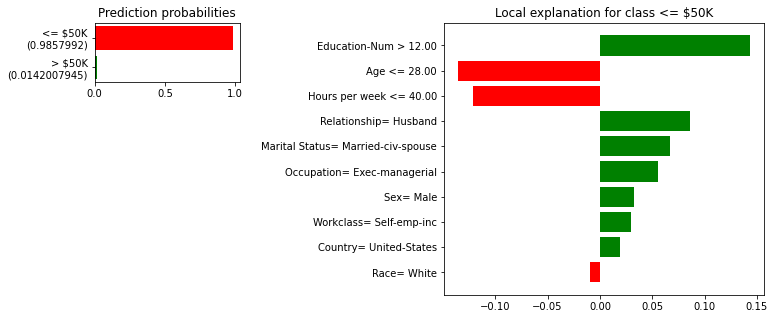

<Figure size 432x288 with 0 Axes>

In [21]:
expM2 = explainer.explain_instance(instanceModified2.values, xgc_np.predict_proba,
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified2.values))
plot_explanation(expM2, mapping)

***
**Task 10**:  How did you choose these features for which you have changed the value? How did you chose these values?





The values I changed was 'Age' from a value greater or equal to 47 to 25 and 'Hours per week' from greater than 45 to 15.
   
As noted before, the features that pushed the prediction higher (shown in red) were; __All other features, but Education was the highest pushed, followed by Hours per Week and Age.__

Age and Hours had signifigant influnece on the higher pediction for class [1], so I reversed it. 

Also noted before in Question 2:

    Based on feature weight, based on the number of times a feature appears in a tree across the ensemble of trees,‘Age’ appeared the most across the trees, followed by ‘Hours per week”.

    Based on Coverage which is based on the average number of samples affected of splits which use the feature, ‘Age’ had the highest f-score, followed close by ‘Martial Status’ and ‘Hours per week’.

It seemed like the features to change, in order to alter the prediction. 

# When a person's income actual is different than predicted

Lime shows which features were the most influential in the model taking the incorrect decision of predicting the person's income. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 11**: Please find a person for which the the prediction is **incorrect**.

***

In [22]:
# Change only the value of to select that person:
k = 4
###########

exp3 = explainer.explain_instance(X_test.iloc[k].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[k].values))
proba3 = xgc_np.predict_proba(X_test.values)[k]

print("********************")
print('Test id: ' , k)
print('Probability(',exp3.class_names[0],") =", exp3.predict_proba[0])
print('Probability(',exp3.class_names[1],") =", exp3.predict_proba[1])
print('Predicted Label:', predictions[k])
print('True class: ' , y_test[k])
print("********************")


Intercept -0.06432393322092908
Prediction_local [0.52476994]
Right: 0.7158443
********************
Test id:  4
Probability( <= $50K ) = 0.28415573
Probability( > $50K ) = 0.7158443
Predicted Label: 1
True class:  0
********************


The classifier got this example classified incorrectly. Let's have a look at the explanation provided by LIME:


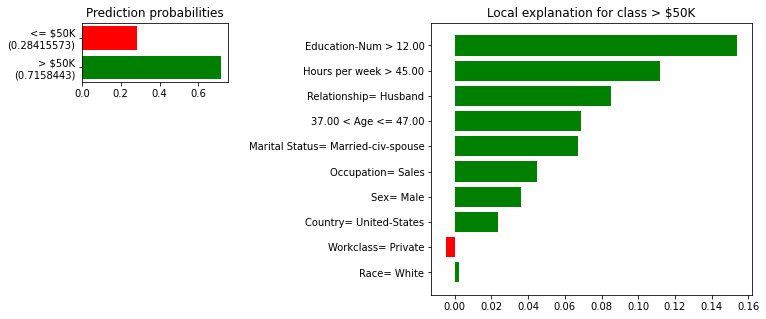

<Figure size 432x288 with 0 Axes>

In [23]:
plot_explanation(exp3, mapping)

***

**Task 12**: Please provide comments on the above explanation provided by LIME.

***

Here, I used the person with an index value of 4 to get the prediction that was incorrect. 
* The model gave a probaility for class [0] (the class we want) of 0.2719934 
* The model gave a probaility for class [1] (the class we don't want) of 0.7280066.
* The true label for this indexed row was 0, the model predicted 1. 
* The model was incorrect.

Based on the Local Explanation for the class:

    Features that pushed the prediction higher (shown in red) were;
        * Workclass and Race had the highest push for class [1].

    Features that pushed the prediction lower (shown in green) were;
        * All other features, but Education-Num was the highest pushed, followed by Hours per week and Martial Status.

***
**Task 13**: Please change the value of one or two features the change the prediction of the classifier (to get a correct prediction):



In [24]:
instanceModified3 = X_test.iloc[k]
instanceModified3['Education-Num'] = 12.0
instanceModified3['Hours per week'] = 15.0
print(instanceModified3)

Age               42.0
Workclass          4.0
Education-Num     12.0
Marital Status     2.0
Occupation        12.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    15.0
Country           39.0
Name: 26674, dtype: float32


Intercept 0.09810076387984412
Prediction_local [0.28750516]
Right: 0.25547254


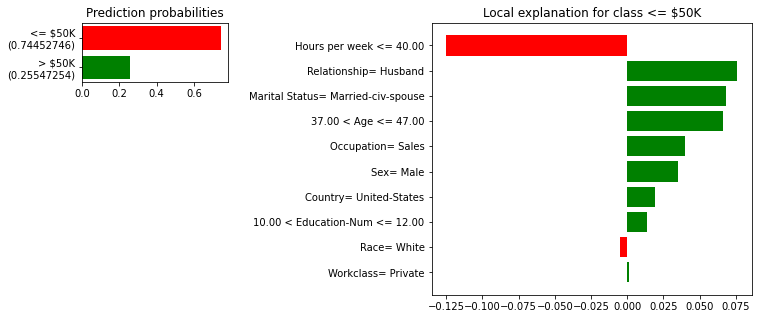

<Figure size 432x288 with 0 Axes>

In [25]:
expM3 = explainer.explain_instance(instanceModified3.values, xgc_np.predict_proba, 
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified3.values))
plot_explanation(expM3, mapping)

***
**Task 14**:  How did you choose these features for which you have changed the value? How did you chose these values?





The values I changed was 'Education-Num' from a value greater or equal to 12 to 12 and 'Hours per week' from greater than 45 to 15.
   
As noted before, the features that pushed the prediction lower (shown in green) were; __Education-Num was the highest pushed, followed by Hours per week and Martial Status__

Age and Hours had signifigant influnece on the higher pediction for class [1], so I reversed it. 

Also noted before in Question 2:

    Based on feature weight, based on the number of times a feature appears in a tree across the ensemble of trees,‘Age’ appeared the most across the trees, followed by ‘Hours per week”.

    Based on Coverage which is based on the average number of samples affected of splits which use the feature, ‘Age’ had the highest f-score, followed close by ‘Martial Status’ and ‘Hours per week’.

It seemed like the features to change, in order to alter the prediction. 

# Decision Tree

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.

Let's use the DecisionTreeClassifier provided by sklearn on our dataset:

In [26]:
tree = DecisionTreeClassifier(random_state=0, max_depth=4).fit(X_train.values, y_train)
tree.fit(X_train.values, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

In [27]:
predictions = tree.predict(X_test)
print("The values predicted for the first 20 test examples are:")
print(predictions[:20])

print("The true values are:")
print(y_test[:20])

The values predicted for the first 20 test examples are:
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
The true values are:
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]


In [28]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7417
           1       0.75      0.40      0.52      2352

    accuracy                           0.82      9769
   macro avg       0.79      0.68      0.71      9769
weighted avg       0.81      0.82      0.80      9769



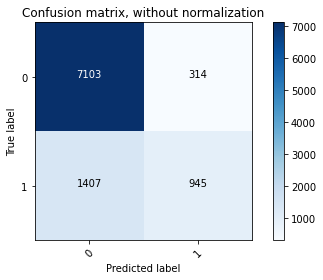

In [29]:
class_labels = list(set(labels))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')

***
**Task 15**:  Please provide comments on the performance of the decision Tree.


Based on the classification report and confusion matrix of the Decision Tree model:
*	7103 labels fell into the True Positive (Upper Right) segment, where the prediction label was 0 and the true label was 0.
*	314 labels fell into the False Positive (Upper Left) segment, where the prediction label was 1 and the true label was 0.
*	1407 labels fell into the False Negative (Lower Left) segment, where the prediction label was 0 and the true label was 1.
*	945 labels fell into the True Negative (Lower Right) segment, where the prediction label was 1 and the true label was 1.

Overall, the model was 82% accurate; 71% accurate based on unweighted mean and 80% accurate based on weighted average.

The model is overall less accurate than the XGB classifier.

# Visualzing the Tree

Let's generate a GraphViz representation of the decision tree:



In [30]:
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=headers, 
                filled=True, rounded=True, impurity= False, class_names=['<=$50K','>$50K'])

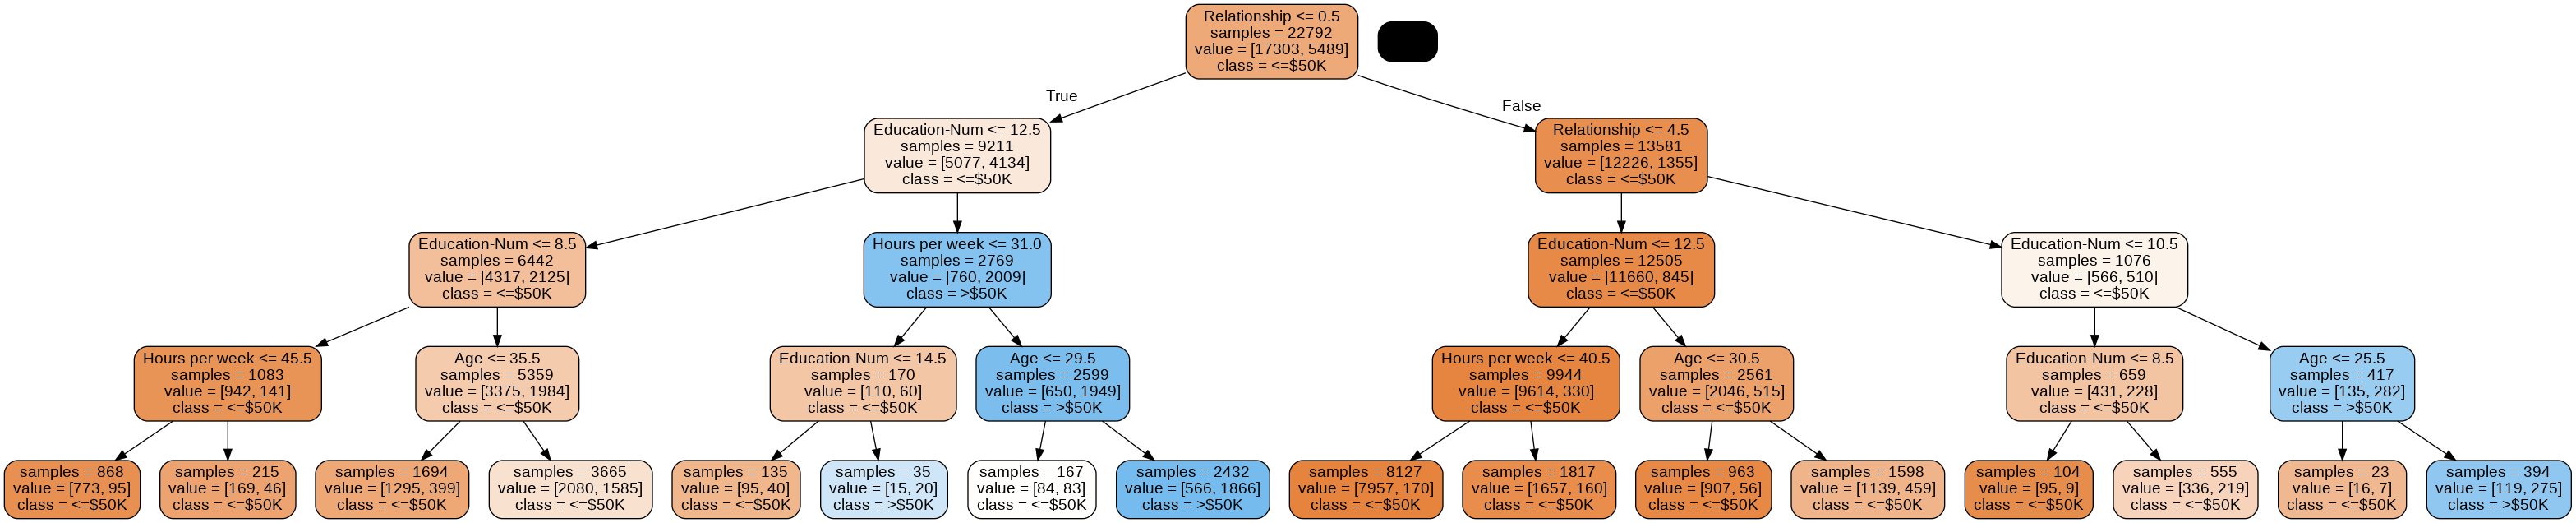

In [31]:
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

***
**Task 16**:  Explain the tree structure (including the meaning of the colors). 


The Tree above represents the the decision tree models classification logic. 

Each box is a node on the tree. There are two types of nodes: 
* Internal nodes are nodes where there was a split, in this case, there are 14 internal nodes.
 * Internal nodes have all the following node metric with an additional metric called the Rule.
 * The first line in each node is the rule that was used to split the node;
        if the rule is true, you go left, if the rule is false, you go right.

* Leaf nodes are nodes at the bottom of the tree, where the tree has stopped growing. 

All nodes have the following metrics:
* Samples are simply the number of samples before the split.
* The value metric are the classes of each of those samples.
* The class metric is the majority class of that node's sample. 
* The goal of each split is to minimise the node impurity. 

The colours of the nodes of the tree represent the impurity of each node, darker colour are nodes with a higher purity and lighter colours are a lower purity. 

As we can see, the white leaf node is perfectly split in regards to the sample class distribution in that node.

We can gauge the model's predictions based on the rules and purity of the leaf nodes. 

For example, we can say that for the darkest leaf, which is used for class <=50k:
* Relationship was a value less than or equal to 4.5.
* Education was a value less than or equal to 12.5
* Hours per week was a value less than or equal to 40.5

# Explanation using LIME

Select any person from the dataset and get the LIME explanation for its classification.

In [32]:
# Change only the value of to select that person:
h = 1
###########

exp4 = explainer.explain_instance(X_test.iloc[h].values, tree.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[h].values))
proba1 = tree.predict_proba(X_test.values)[h]

print("********************")
print('Test id: ' , h)
print('Probability(',exp4.class_names[0],") =", exp4.predict_proba[0])
print('Probability(',exp4.class_names[1],") =", exp4.predict_proba[1])
print('Predicted Label:', predictions[h])
print('True class: ' , y_test[h])
print("********************")

Intercept 0.22990793579317798
Prediction_local [0.31635276]
Right: 0.30434782608695654
********************
Test id:  1
Probability( <= $50K ) = 0.6956521739130435
Probability( > $50K ) = 0.30434782608695654
Predicted Label: 0
True class:  0
********************


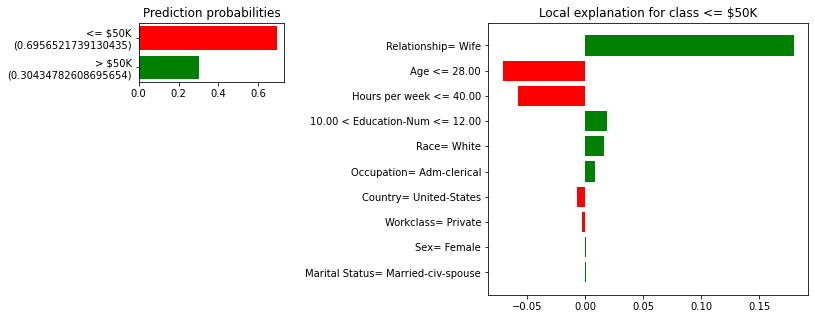

<Figure size 432x288 with 0 Axes>

In [33]:
plot_explanation(exp4, mapping)

***
**Task 17**:  Please provide comments on the above explanation provided by LIME using on the Tree structure above as a context to your explanation.


Here, the person with an index value of 1 to get the prediction.
* The model gave a probaility for class [0] (the person makes less than or equal to 50k) of 0.6956521739130435. 
* The model gave a probaility for class [1] (the person makes more than 50k) of 0.30434782608695654.
* The true label for this indexed row was 0, the model predicted 0. 
* The model was correct.

Based on the Local Explanation for the classes, it shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output.

Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

    Features that pushed the prediction higher (shown in red) were;
        * Age value that is less than or equal to 28.00
        * Hours per week with a value less than or equal to 40.00.
        * Occupation listed as Adm-clerical
        * Sex is listed as female.
        * Race is listed as White
        * Country is listed as USA.
        * Marital Status listed as Married.

    Features that pushed the prediction lower (shown in green) were;
        * Relationship listed as Wife.
        * Education-Num being between 10 and 12. 
        
In regards to the Tree structure, we discussed above, we can follow the node-leaf structure:
* The initial node was split based on the 'Relationship' value. Since it has the largest imapact on the probability, it would be ideal first split by the model.
* The next split node was probably 'Age', as it had the second largest impact.
* The next split node was 'Hours per Week', as it is the third largest impact and is used by the initial model for a large number of splits. 
* The last split was the 'Education' value. 
* By this point, the model has evaluated all the values that have signifigant impact on the probability and also covered all the features it found that gave it the best purity based on the training data.
* It was then above to conclude with a 70/30 chance where the prediction would fall. 


# Your own test example

**Task 18**: Following the tree above, create your own test example that will be classified as income > $\$50$K by the decision tree. Explain how you select the values for the features. Use LIME to provide explanation to that test example.

In [34]:
# Change only the value of to select that person:
h = 1
instanceModifiedX = X_test.iloc[h]
instanceModifiedX['Age'] = 48.0
instanceModifiedX['Workclass'] = 1
instanceModifiedX['Education-Num'] = 15.0
instanceModifiedX['Marital Status'] = 0
instanceModifiedX['Occupation'] = 4.0
instanceModifiedX['Relationship'] = 0
instanceModifiedX['Race'] = 0
instanceModifiedX['Sex'] = 1
instanceModifiedX['Hours per week'] = 60
instanceModifiedX['Country'] = 39
print(instanceModifiedX)

Age               48.0
Workclass          1.0
Education-Num     15.0
Marital Status     0.0
Occupation         4.0
Relationship       0.0
Race               0.0
Sex                1.0
Hours per week    60.0
Country           39.0
Name: 26705, dtype: float32


Intercept 0.02469679703089267
Prediction_local [0.56394406]
Right: 0.7672697368421053
********************
Test id:  1
Probability( <= $50K ) = 0.23273026315789475
Probability( > $50K ) = 0.7672697368421053
Predicted Label: 0
True class:  0
********************


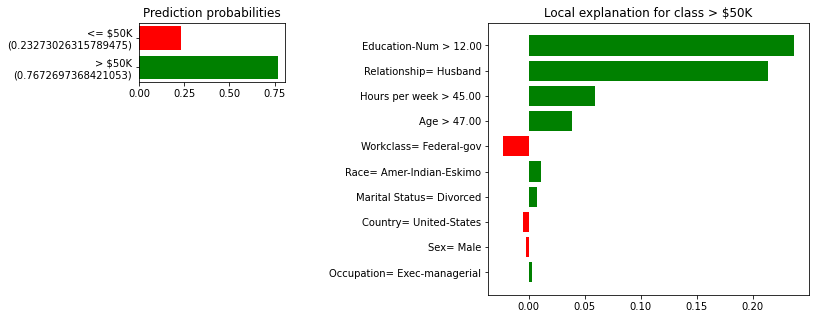

<Figure size 432x288 with 0 Axes>

In [35]:
expMX = explainer.explain_instance(instanceModifiedX.values, tree.predict_proba,
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModifiedX.values))
plot_explanation(expMX, mapping)

print("********************")
print('Test id: ' , h)
print('Probability(',expMX.class_names[0],") =", expMX.predict_proba[0])
print('Probability(',expMX.class_names[1],") =", expMX.predict_proba[1])
print('Predicted Label:', predictions[h])
print('True class: ' , y_test[h])
print("********************")

I constructed my test set based on the above analysis from the tree model:

For example, we can say that for the darkest leaf, which is used for class <=50k:
* Relationship was a value less than or equal to 4.5.
* Education was a value less than or equal to 12.5
* Hours per week was a value less than or equal to 40.5

So when creating my test data set, I simply opted the reverse of these values for the opposite class result.
* Relationship was a value greater than 4.5.
* Education was a value greater than 12.5
* Hours per week was a value greater than 40.5

# LIME for explaining prediction images

**Task 19**: Use the [CIFAR100](https://www.cs.toronto.edu/~kriz/cifar.html) to build an image classifier, and then use the LIME framework with visualization to explain a few predicionts. You can use any classifier for this task (Neural network, Logistic regression, etc.).



In [36]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers
from numpy import mean
from numpy import std
from lime import lime_image
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

In [73]:
(xip_train, yip_train), (xip_test, yip_test) = datasets.cifar100.load_data(label_mode='coarse')
xip_train, xip_test = xip_train.astype('float32') / 255.0, xip_test.astype('float32') / 255.0
xip_train = xip_train.reshape(-1,32,32,3).transpose(0,1,2,3)
xip_test = xip_test.reshape(-1,32,32,3).transpose(0,1,2,3)

nb_classes= len(np.unique(yip_train))
yip_train = tf.keras.utils.to_categorical(yip_train)
yip_test = tf.keras.utils.to_categorical(yip_test)

xip_train.shape, xip_test.shape, yip_train.shape, yip_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 20), (10000, 20))

In [74]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(20, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               1048704   
                                                                 
 dense_13 (Dense)            (None, 20)                2580      
                                                      

In [75]:
model.compile(optimizer='SGD',loss='categorical_crossentropy',metrics=['accuracy'])

In [76]:
model.fit(xip_train,yip_train,epochs=2)

Epoch 1/2
1563/1563 [==============================] - 163s 103ms/step - loss: 2.5102 - accuracy: 0.2317
Epoch 2/2
1563/1563 [==============================] - 154s 99ms/step - loss: 2.1687 - accuracy: 0.3367


In [77]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Y_test_preds = model.predict(xip_test)
Y_test_preds = np.argmax(Y_test_preds, axis=1)
rounded_labels=np.argmax(yip_test, axis=1)

print(classification_report(rounded_labels, Y_test_preds))

              precision    recall  f1-score   support

           0       0.24      0.47      0.32       500
           1       0.53      0.19      0.28       500
           2       0.56      0.61      0.58       500
           3       0.53      0.19      0.28       500
           4       0.52      0.36      0.42       500
           5       0.34      0.31      0.32       500
           6       0.48      0.20      0.28       500
           7       0.30      0.47      0.37       500
           8       0.18      0.42      0.25       500
           9       0.45      0.44      0.45       500
          10       0.75      0.37      0.49       500
          11       0.19      0.40      0.26       500
          12       0.18      0.45      0.25       500
          13       0.22      0.05      0.08       500
          14       0.42      0.47      0.44       500
          15       0.21      0.08      0.12       500
          16       0.19      0.11      0.14       500
          17       0.60    

In [81]:
ipexplainer = lime_image.LimeImageExplainer()

In [96]:
ipexplanation = ipexplainer.explain_instance(xip_test[2].astype('double'), model.predict, top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1st predicted class is 0 , class 0, which is Aquatic Animals
2nd predicted class is 11 Class 11, which is large natural outdoor scenes
3rd predicted class is 7 Class 7, which is household furniture


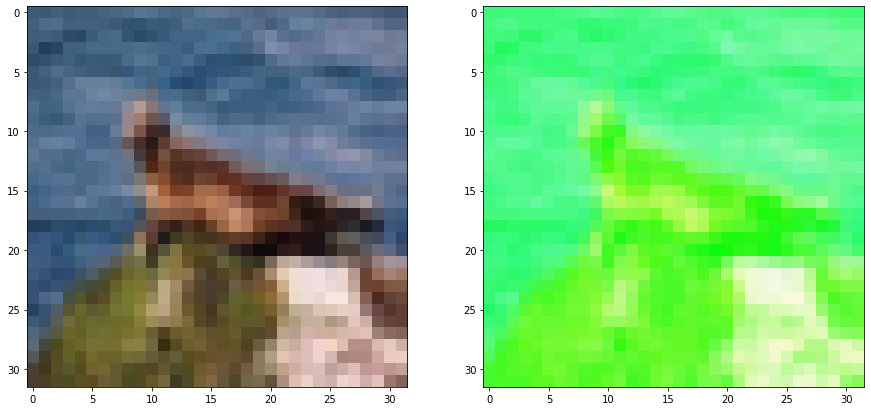

In [104]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = ipexplanation.get_image_and_mask(ipexplanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = ipexplanation.get_image_and_mask(ipexplanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

print("1st predicted class is" , ipexplanation.top_labels[0] , ", class 0, which is Aquatic Animals")
print("2nd predicted class is" , ipexplanation.top_labels[1] , "Class 11, which is large natural outdoor scenes")
print("3rd predicted class is" , ipexplanation.top_labels[2] , "Class 7, which is household furniture")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))

For this task, I used the the CIFAR100 dataset with a CNN (Conventional Neural Network. 

CIFAR-100 is a well-understood dataset and widely used for benchmarking computer vision algorithms in the field of machine learning. This dataset is often used in testing of deep learning convolutional neural networks.

The CIFAR100 has 100 classes with 600 images each.
There are 500 training images and 100 testing images per class.

Each set of 20 classes are known as 'superclasses', I used the superclasses for my sequential model. 

* conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                               
* conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
* max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
* flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
* dense_12 (Dense)            (None, 128)               1048704   
                                                                 
* dense_13 (Dense)            (None, 20)                2580      
                                                               
  * Total params: 1,061,428


The output above shows 2 images:
* The left image, we can the super-pixels on the image are shown. This means that our model classifies our image because of these super-pixels.

* On the right image, the area of super-pixels colored in green are the ones that increase the probability of our image belongs to a certain class.

Overall our model predicted three classes; 0 , 11 & 7.
* Class 0 is 'Aquatic Mammals', which is the true label of the the index 2 test image. Our model correctly identified the test image.   


# Congratulations!

You've come to the end of this assignment, and have seen a lot of the ways to explain the predictions given by a classifier.

Congratulations on finishing this notebook! 

